In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from pandas import factorize
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, MaxPool2D
from tensorflow.keras.layers import Conv2D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
#Compiling mutiple csv's to a single dataframe
li = []
for i in range(16,31):
    train = pd.read_csv("csh1"+str(i)+".ann.features.csv")
    li.append(train)
df = pd.concat(li, axis=0, ignore_index=True)

In [3]:
#Considering only the below 8 classes
classes = ['Toilet', 'Leave_Home', 'Enter_Home', 'Cook_Dinner', 'Eat_Dinner', 'Sleep', 'Watch_TV', 'Work_At_Table']
df = df[df.activity.isin(classes)]

In [4]:
X = df.loc[:,df.columns!='activity']
y = df.loc[:,df.columns== 'activity']

**Exploratory Data Analysis**

<AxesSubplot:>

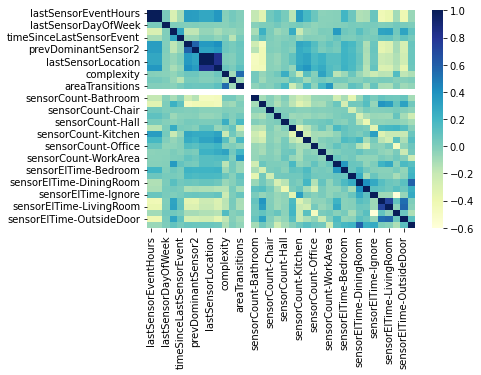

In [5]:
sns.heatmap(df.corr(), annot=False, cmap="YlGnBu")

In [6]:
# Check the data types
print(df.dtypes)

lastSensorEventHours        float64
lastSensorEventSeconds      float64
lastSensorDayOfWeek         float64
windowDuration              float64
timeSinceLastSensorEvent    float64
prevDominantSensor1         float64
prevDominantSensor2         float64
lastSensorID                float64
lastSensorLocation          float64
lastMotionLocation          float64
complexity                  float64
activityChange              float64
areaTransitions             float64
numDistinctSensors          float64
sensorCount-Bathroom        float64
sensorCount-Bedroom         float64
sensorCount-Chair           float64
sensorCount-DiningRoom      float64
sensorCount-Hall            float64
sensorCount-Ignore          float64
sensorCount-Kitchen         float64
sensorCount-LivingRoom      float64
sensorCount-Office          float64
sensorCount-OutsideDoor     float64
sensorCount-WorkArea        float64
sensorElTime-Bathroom       float64
sensorElTime-Bedroom        float64
sensorElTime-Chair          

In [7]:
# Check the shape of the dataframe
print(df.shape)

(688743, 37)


In [8]:
#Statistical Data of lastSensorEventHours
df["lastSensorEventHours"].describe()

count    688743.000000
mean         14.195450
std           5.811066
min           0.000000
25%          10.000000
50%          16.000000
75%          19.000000
max          23.000000
Name: lastSensorEventHours, dtype: float64

In [9]:
#Statistical Data of lastSensorEventSeconds
df["lastSensorEventSeconds"].describe()

count    688743.000000
mean      52907.670185
std       20912.108502
min           0.000000
25%       37030.000000
50%       59686.000000
75%       68499.000000
max       86399.000000
Name: lastSensorEventSeconds, dtype: float64

In [10]:
# Get the counts for each unique value in each column
for col in df.columns:
    print(df[col].value_counts())
    print('\n____________________________________________________________________\n')

17.0    79616
18.0    66110
19.0    57042
16.0    46189
21.0    36745
20.0    35277
15.0    30067
8.0     29315
10.0    27561
9.0     27166
7.0     26505
13.0    25877
14.0    25868
22.0    25438
11.0    25412
12.0    23672
23.0    19869
6.0     18315
0.0     13251
5.0     11454
4.0     10468
1.0      9612
3.0      9150
2.0      8764
Name: lastSensorEventHours, dtype: int64

____________________________________________________________________

64766.0    51
64703.0    48
64718.0    47
64489.0    46
64571.0    46
           ..
19863.0     1
44868.0     1
19217.0     1
18022.0     1
80024.0     1
Name: lastSensorEventSeconds, Length: 84315, dtype: int64

____________________________________________________________________

6.0    111630
5.0     99266
4.0     99009
3.0     98465
0.0     95364
2.0     94351
1.0     90658
Name: lastSensorDayOfWeek, dtype: int64

____________________________________________________________________

41.0       5125
46.0       5105
47.0       5071
42.0       5

In [11]:
# Group the data by lastSensorDayOfWeek and calculate the mean for each group
df.groupby('lastSensorDayOfWeek')['windowDuration'].mean()

lastSensorDayOfWeek
0.0    1002.667160
1.0    1003.713440
2.0     982.357590
3.0    1017.669426
4.0    1044.169702
5.0     971.481333
6.0     941.977578
Name: windowDuration, dtype: float64

In [12]:
# Group the data by activityLabel and calculate the median for each group
df.groupby('activity')['lastSensorEventSeconds'].median()

activity
Cook_Dinner      65493.0
Eat_Dinner       68360.0
Enter_Home       52283.0
Leave_Home       46843.0
Sleep            25433.0
Toilet           47025.0
Watch_TV         63567.0
Work_At_Table    50787.0
Name: lastSensorEventSeconds, dtype: float64

In [13]:
# Subset the data for the morning (hours 0-11)
morning_df = df.query('lastSensorEventHours <= 11')

# Subset the data for the afternoon (hours 12-17)
afternoon_df = df.query('lastSensorEventHours >= 12 and lastSensorEventHours <= 17')

# Subset the data for the evening (hours 18-23)
evening_df = df.query('lastSensorEventHours >= 18')

In [14]:
# Subset the data for weekdays (Monday-Friday)
weekday_df = df[df['lastSensorDayOfWeek'].isin([0, 1, 2, 3, 4, 5])]

# Subset the data for weekends (Saturday-Sunday)
weekend_df = df[df['lastSensorDayOfWeek'].isin([5, 6])]

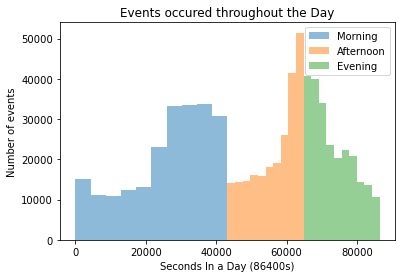

In [15]:
# Plot histograms for lastSensorEventSeconds in the morning, afternoon, and evening

plt.hist(morning_df['lastSensorEventSeconds'], alpha=0.5, label='Morning')
plt.hist(afternoon_df['lastSensorEventSeconds'], alpha=0.5, label='Afternoon')
plt.hist(evening_df['lastSensorEventSeconds'], alpha=0.5, label='Evening')
plt.xlabel('Seconds In a Day (86400s)')
plt.ylabel('Number of events')
plt.title('Events occured throughout the Day')
plt.legend()
plt.show()

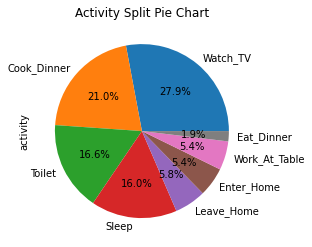

In [16]:
# Plot a pie chart for activity
df['activity'].value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.title("Activity Split Pie Chart")
plt.show()

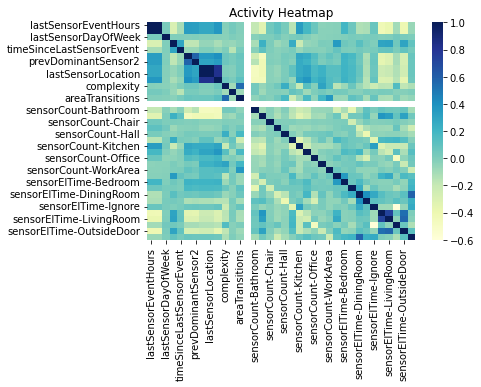

In [17]:
# Calculate the correlation between columns
corr = df.corr()

# Plot a heatmap for the correlation matrix
sns.heatmap(df.corr(), annot=False, cmap="YlGnBu")
plt.title("Activity Heatmap")
plt.show()

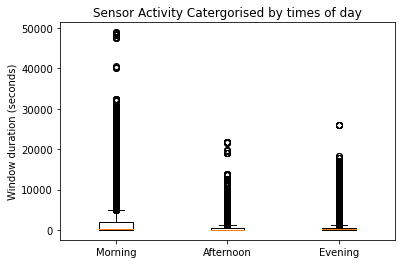

In [18]:
# Plot box plots for windowDuration in the morning, afternoon, and evening
plt.boxplot([morning_df['windowDuration'], afternoon_df['windowDuration'], evening_df['windowDuration']], labels=['Morning', 'Afternoon', 'Evening'])
plt.ylabel('Window duration (seconds)')
plt.title("Sensor Activity Catergorised by times of day")
plt.show()

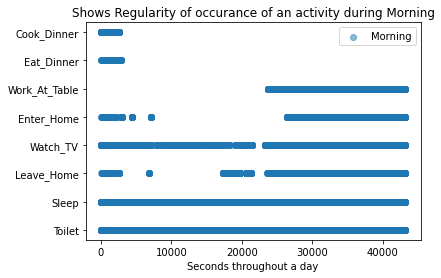

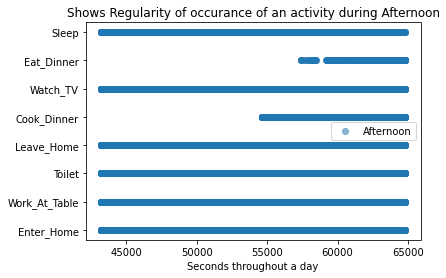

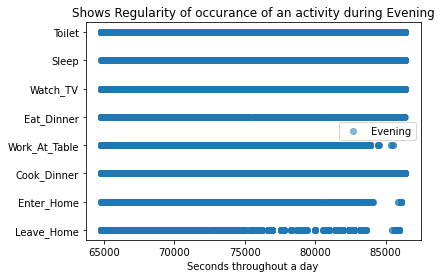

In [19]:
# Plot scatter plots for lastSensorEventSeconds vs. windowDuration in the morning,afternoon and evening
plt.scatter(morning_df['lastSensorEventSeconds'], morning_df['activity'], alpha=0.5, label='Morning')
plt.xlabel('Seconds throughout a day')
plt.title('Shows Regularity of occurance of an activity during Morning')
plt.legend()
plt.show()
plt.scatter(afternoon_df['lastSensorEventSeconds'], afternoon_df['activity'], alpha=0.5, label='Afternoon')
plt.xlabel('Seconds throughout a day')
plt.title('Shows Regularity of occurance of an activity during Afternoon')
plt.legend()
plt.show()
plt.scatter(evening_df['lastSensorEventSeconds'], evening_df['activity'], alpha=0.5, label='Evening')
plt.xlabel('Seconds throughout a day')
plt.title('Shows Regularity of occurance of an activity during Evening')
plt.legend()
plt.show()

In [20]:
# Calculate the correlations between columns on weekdays and weekends
weekday_corr = weekday_df.corr()
weekend_corr = weekend_df.corr()

# Calculate the correlations between columns in the morning and evening
morning_corr = morning_df.corr()
afternoon_corr = afternoon_df.corr()
evening_corr = evening_df.corr()

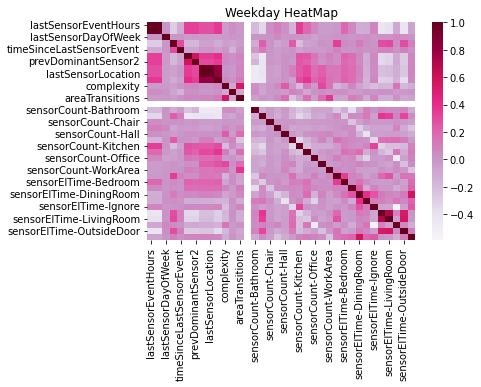

In [21]:
# Plot heatmaps for the correlation matrices Weekday
sns.heatmap(weekday_corr,  annot=False, fmt='.2f', cmap="PuRd")
plt.title('Weekday HeatMap')
plt.show()

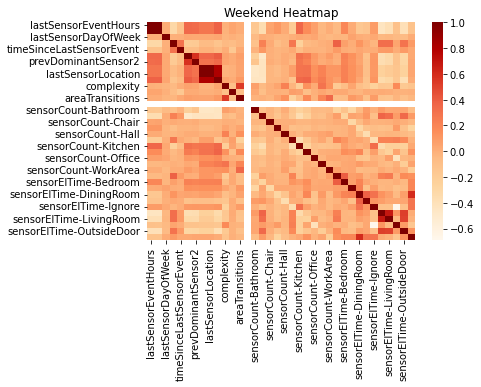

In [22]:
# Plot heatmaps for the correlation matrices Weekend
sns.heatmap(weekend_corr,  annot=False, fmt='.2f', cmap="OrRd")
plt.title('Weekend Heatmap')
plt.show()

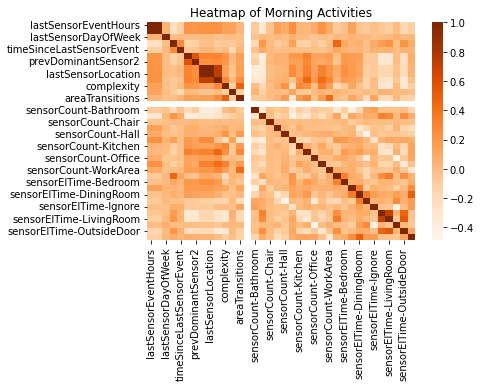

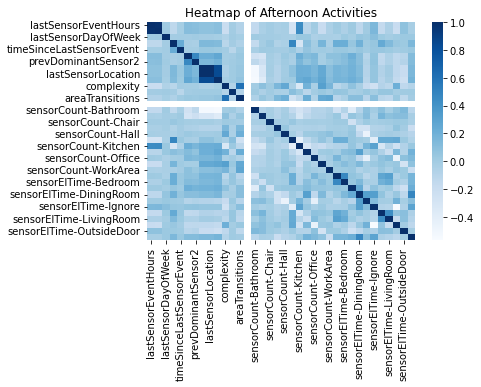

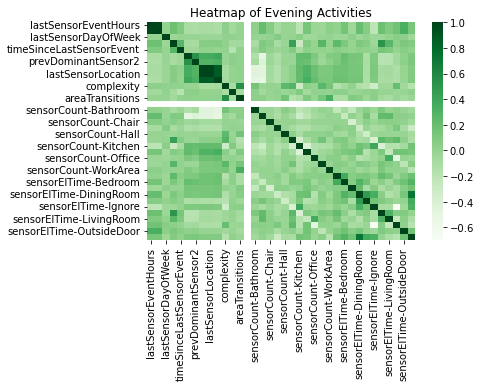

In [23]:
# Plot heatmaps for the correlation matrices through segments of the day
sns.heatmap(morning_corr, cmap='Oranges', annot=False, fmt='.2f')
plt.title('Heatmap of Morning Activities')
plt.show()
sns.heatmap(afternoon_corr, cmap='Blues', annot=False, fmt='.2f')
plt.title('Heatmap of Afternoon Activities')
plt.show()
sns.heatmap(evening_corr, cmap='Greens', annot=False, fmt='.2f')
plt.title('Heatmap of Evening Activities')
plt.show()

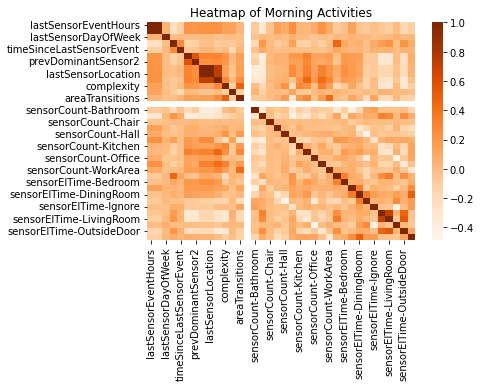

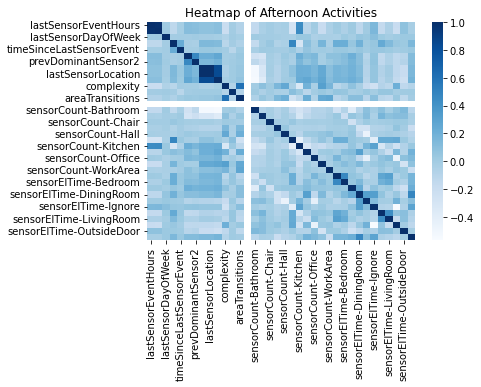

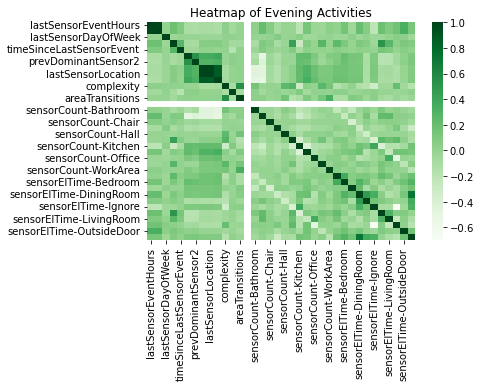

In [24]:
# Plot heatmaps for the correlation matrices through segments of the day
sns.heatmap(morning_corr, cmap='Oranges', annot=False, fmt='.2f')
plt.title('Heatmap of Morning Activities')
plt.show()
sns.heatmap(afternoon_corr, cmap='Blues', annot=False, fmt='.2f')
plt.title('Heatmap of Afternoon Activities')
plt.show()
sns.heatmap(evening_corr, cmap='Greens', annot=False, fmt='.2f')
plt.title('Heatmap of Evening Activities')
plt.show()

In [25]:
# Select the columns to use as features
features = ['lastSensorEventHours', 'lastSensorEventSeconds', 'lastSensorDayOfWeek', 'windowDuration', 'timeSinceLastSensorEvent', 'prevDominantSensor1', 'prevDominantSensor2', 'lastSensorID', 'lastSensorLocation', 'lastMotionLocation']
Z = df[features]

# Initialize the KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3)

# Fit the model to the data
kmeans.fit(Z)

# Predict the cluster labels for each event
y_pred = kmeans.predict(Z)

# Add the predicted cluster labels to the dataframe
df['cluster'] = y_pred

In [26]:
# Select the columns to use as features
features = ['lastSensorEventHours', 'lastSensorEventSeconds', 'lastSensorDayOfWeek', 'windowDuration', 'timeSinceLastSensorEvent', 'prevDominantSensor1', 'prevDominantSensor2', 'lastSensorID', 'lastSensorLocation', 'lastMotionLocation']
weekday_X = weekday_df[features]
weekend_X = weekend_df[features]

# Initialize the KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3)

# Fit the model to the data
kmeans.fit(weekday_X)
kmeans.fit(weekend_X)

# Predict the cluster labels for each event
weekday_y_pred = kmeans.predict(weekday_X)
weekend_y_pred = kmeans.predict(weekend_X)

# Add the predicted cluster labels to the dataframe
weekday_df['cluster'] = weekday_y_pred
weekend_df['cluster'] = weekend_y_pred

C:\Users\raja3\AppData\Local\Temp/ipykernel_39040/73537976.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday_df['cluster'] = weekday_y_pred
C:\Users\raja3\AppData\Local\Temp/ipykernel_39040/73537976.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_df['cluster'] = weekend_y_pred


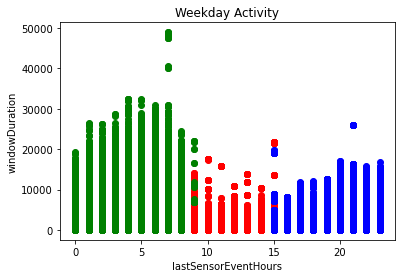

In [27]:
# Select the columns to use for the x- and y-axes
x_col = 'lastSensorEventHours'
y_col = 'windowDuration'

# Create a scatter plot with different colors for each cluster
colors = ['red', 'green', 'blue']
for i in range(3):
    cluster_df = weekday_df[weekday_df['cluster'] == i]
    plt.scatter(cluster_df[x_col], cluster_df[y_col], color=colors[i])

# Add labels to the axes
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title("Weekday Activity")
# Show the plot
plt.show()

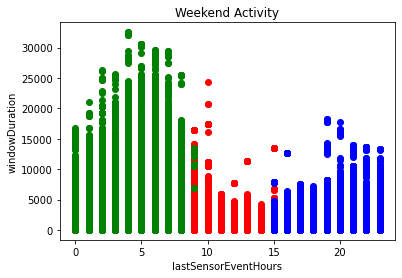

In [28]:
# Select the columns to use for the x- and y-axes
x_col = 'lastSensorEventHours'
y_col = 'windowDuration'

# Create a scatter plot with different colors for each cluster
colors = ['red', 'green', 'blue']
for i in range(3):
    cluster_df = weekend_df[weekend_df['cluster'] == i]
    plt.scatter(cluster_df[x_col], cluster_df[y_col], color=colors[i])

# Add labels to the axes
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title("Weekend Activity")
# Show the plot
plt.show()

In [29]:
# Select the columns to use as features
features = ['lastSensorEventHours', 'lastSensorEventSeconds', 'lastSensorDayOfWeek', 'windowDuration', 'timeSinceLastSensorEvent', 'prevDominantSensor1', 'prevDominantSensor2', 'lastSensorID', 'lastSensorLocation', 'lastMotionLocation']
X = df[features]

# Initialize the PCA model with 2 components
pca = PCA(n_components=2)

# Fit the model to the data
pca.fit(X)

# Transform the data into the new lower-dimensional space
X_pca = pca.transform(X)

# Add the transformed data to the dataframe
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

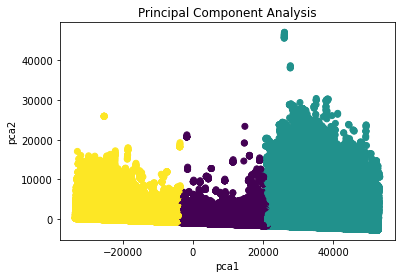

In [30]:
# Select the columns to use for the x- and y-axes, as well as the color map
x_col = 'pca1'
y_col = 'pca2'
c_map = 'cluster'

# Create a scatter plot of the data, with different colors for each cluster
plt.scatter(df[x_col], df[y_col], c=df[c_map], cmap='viridis')

# Add labels to the axes
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title("Principal Component Analysis")

# Show the plot
plt.show()

In [31]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [40]:
#Reading files once again
li = []
for i in range(16,31):
    train = pd.read_csv("csh1"+str(i)+".ann.features.csv")
    li.append(train)
df = pd.concat(li, axis=0, ignore_index=True)

#Considering only the below 8 classes
classes = ['Toilet', 'Leave_Home', 'Enter_Home', 'Cook_Dinner', 'Eat_Dinner', 'Sleep', 'Watch_TV', 'Work_At_Table']
df = df[df.activity.isin(classes)]

X = df.loc[:,df.columns!='activity']
y = df.loc[:,df.columns== 'activity']
X = remove_collinear_features(X, 0.7)

lastSensorEventSeconds | lastSensorEventHours | 1.0
lastSensorLocation | lastSensorID | 1.0
lastMotionLocation | lastSensorID | 0.82
lastMotionLocation | lastSensorLocation | 0.82
sensorElTime-LivingRoom | sensorElTime-Kitchen | 0.73


In [42]:
scaler = MaxAbsScaler()
scaler.fit(X)
scaled = scaler.transform(X)
X = pd.DataFrame(scaled, columns=X.columns)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Class=Watch_TV, n=129103 (18.745%)
Class=Toilet, n=76648 (11.129%)
Class=Work_At_Table, n=24770 (3.596%)
Class=Sleep, n=73568 (10.681%)
Class=Cook_Dinner, n=96754 (14.048%)
Class=Enter_Home, n=24943 (3.622%)
Class=Leave_Home, n=26891 (3.904%)
Class=Eat_Dinner, n=8780 (1.275%)


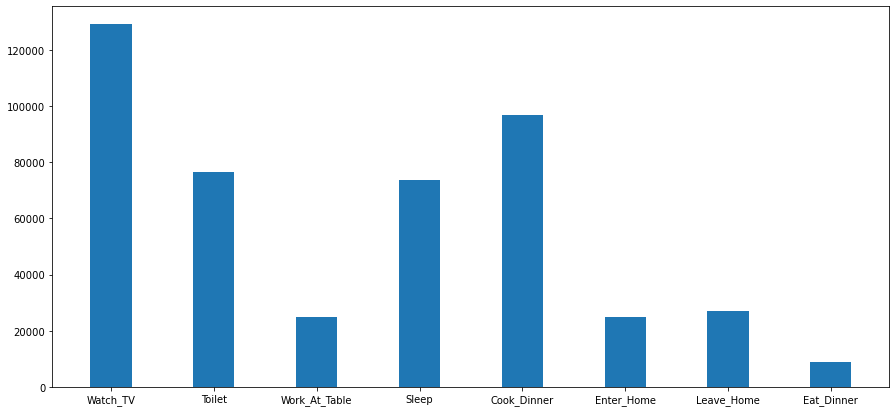

In [44]:
from collections import Counter
from matplotlib import pyplot
counter = Counter(y_train['activity'])
for k, v in counter.items():
    per = v / len(y) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
fig = plt.figure(figsize =(15, 7))
pyplot.bar(counter.keys(), counter.values(), width = 0.4)
pyplot.show()

In [45]:
import imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

Class=Watch_TV, n=129103 (18.745%)
Class=Toilet, n=129103 (18.745%)
Class=Work_At_Table, n=129103 (18.745%)
Class=Sleep, n=129103 (18.745%)
Class=Cook_Dinner, n=129103 (18.745%)
Class=Enter_Home, n=129103 (18.745%)
Class=Leave_Home, n=129103 (18.745%)
Class=Eat_Dinner, n=129103 (18.745%)


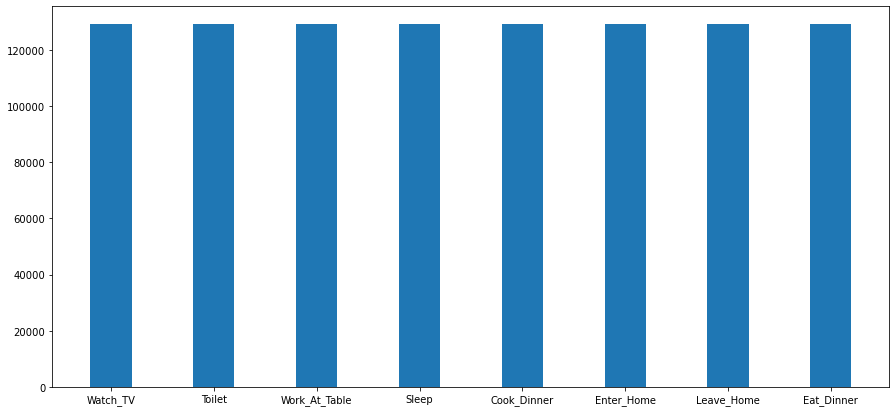

In [46]:
from collections import Counter
from matplotlib import pyplot
counter = Counter(y_train['activity'])
for k, v in counter.items():
    per = v / len(y) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
fig = plt.figure(figsize =(15, 7))
pyplot.bar(counter.keys(), counter.values(), width = 0.4)
pyplot.show()

In [47]:
from sklearn import preprocessing
from keras.utils import to_categorical
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test_enc = encoder.transform(y_test)
y_train = to_categorical(y_train, num_classes=8)
y_test_enc = to_categorical(y_test_enc, num_classes=8)

C:\Users\raja3\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\raja3\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Multi Layer Perceptron**

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense

MLP = Sequential()
MLP.add(InputLayer(input_shape=(X_train.shape[1], ))) # input layer
MLP.add(Dense(256, activation='relu')) # hidden layer 1
MLP.add(Dense(256, activation='relu')) # hidden layer 2
MLP.add(Dense(8, activation='softmax')) # output layer

# summary
MLP.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               8448      
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 76,296
Trainable params: 76,296
Non-trainable params: 0
_________________________________________________________________


In [101]:
MLP.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics = ['AUC', 'Precision', 'Recall', 'Accuracy'])

In [118]:
MLP.fit(X_train, y_train, epochs=20, batch_size = 100)

Epoch 1/20
10329/10329 [==============================] - 17s 2ms/step - loss: 0.0109 - auc: 0.9998 - precision: 0.9966 - recall: 0.9965 - Accuracy: 0.9965
Epoch 2/20
10329/10329 [==============================] - 16s 2ms/step - loss: 0.0103 - auc: 0.9998 - precision: 0.9967 - recall: 0.9966 - Accuracy: 0.9967
Epoch 3/20
10329/10329 [==============================] - 16s 2ms/step - loss: 0.0102 - auc: 0.9999 - precision: 0.9968 - recall: 0.9967 - Accuracy: 0.9967
Epoch 4/20
10329/10329 [==============================] - 16s 2ms/step - loss: 0.0101 - auc: 0.9998 - precision: 0.9968 - recall: 0.9968 - Accuracy: 0.9968
Epoch 5/20
10329/10329 [==============================] - 16s 2ms/step - loss: 0.0100 - auc: 0.9998 - precision: 0.9969 - recall: 0.9968 - Accuracy: 0.9968
Epoch 6/20
10329/10329 [==============================] - 16s 2ms/step - loss: 0.0101 - auc: 0.9998 - precision: 0.9970 - recall: 0.9969 - Accuracy: 0.9969
Epoch 7/20
10329/10329 [==============================] - 16s 2m

In [ ]:
test_loss, test_AUC, test_precision, test_recall, test_Accuracy = MLP.evaluate(X_test, y_test_enc,
                                   verbose=1)
print("Test loss:", test_loss)
print("Test AUC:", test_AUC)
print("Test precision:", test_precision)
print("Test recall:", test_recall)
print("Test accuracy:", test_Accuracy)

In [104]:
train_loss, train_AUC, train_precision, train_recall, train_Accuracy = MLP.evaluate(X_train, y_train,
                                   verbose=1)
print("Test loss:", train_loss)
print("Test AUC:", train_AUC)
print("Test precision:", train_precision)
print("Test recall:", train_recall)
print("Test accuracy:", train_Accuracy)

32276/32276 [==============================] - 28s 853us/step - loss: 0.0306 - auc: 0.9993 - precision: 0.9908 - recall: 0.9905 - Accuracy: 0.9906
Test loss: 0.030556626617908478
Test AUC: 0.9993356466293335
Test precision: 0.9908384680747986
Test recall: 0.9904988408088684
Test accuracy: 0.9906450510025024


In [121]:
from numpy import argmax
y_pred = np.round(MLP.predict(X_test))
y_pred_labels = encoder.inverse_transform(argmax(y_pred, axis = 1)) 

7103/7103 [==============================] - 5s 631us/step


In [122]:
from sklearn.metrics import confusion_matrix

In [123]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_labels)

In [124]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

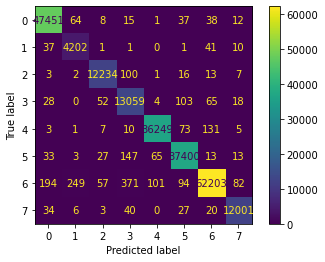

In [125]:
cm_display.plot()
plt.show()

**Convolutional Neural Network**

In [86]:
keras.backend.clear_session()

In [87]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape = (32, 1)))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))

In [98]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 8)                 3848      
                                                                 
Total params: 3,976
Trainable params: 3,976
Non-trainable params: 0
_________________________________________________________________


In [89]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=['Accuracy'])

In [120]:
# fitting model
model.fit(np.expand_dims(np.expand_dims(X_train.values, axis = -1), axis = -1), y_train, epochs=10, verbose=1, batch_size = 100)


Epoch 1/10
10329/10329 [==============================] - 20s 2ms/step - loss: nan - Accuracy: 0.1250
Epoch 2/10
10329/10329 [==============================] - 18s 2ms/step - loss: nan - Accuracy: 0.1250
Epoch 3/10
10329/10329 [==============================] - 19s 2ms/step - loss: nan - Accuracy: 0.1250
Epoch 4/10
10329/10329 [==============================] - 19s 2ms/step - loss: nan - Accuracy: 0.1250
Epoch 5/10
10329/10329 [==============================] - 18s 2ms/step - loss: nan - Accuracy: 0.1250
Epoch 6/10
10329/10329 [==============================] - 18s 2ms/step - loss: nan - Accuracy: 0.1250
Epoch 7/10
10329/10329 [==============================] - 18s 2ms/step - loss: nan - Accuracy: 0.1250
Epoch 8/10
10329/10329 [==============================] - 18s 2ms/step - loss: nan - Accuracy: 0.1250
Epoch 9/10
10329/10329 [==============================] - 18s 2ms/step - loss: nan - Accuracy: 0.1250
Epoch 10/10
10329/10329 [==============================] - 20s 2ms/step - loss: na

In [95]:
# evaluate model
test_loss, test_Accuracy = model.evaluate(X_test, y_test_enc,
                                   verbose=1)
print("Test accuracy:", test_Accuracy)

7103/7103 [==============================] - 5s 709us/step - loss: nan - Accuracy: 0.2095
Test accuracy: 0.2095421701669693
